# General SPT TESS overlap for optical flare data finding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pandas as pd

from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

import lightkurve as lk
import tessreduce as tr

import pickle

c:\Users\vishn\miniconda3\envs\SPT_Flares\lib\site-packages\lightkurve\config\__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to C:\Users\vishn\.lightkurve\cache. Please move all the files in the legacy directory C:\Users\vishn\.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


# Load TESS Data

In [113]:
TESS_sectors_df = pd.read_csv("..\data\TESS\TESS_orbit_times.csv")
# Times are stored by orbit, so first merge by sector
TESS_sectors_df = TESS_sectors_df.groupby("Sector").agg({
    "Start of Orbit": "min",
    "End of Orbit": "max"
}).reset_index()
TESS_sectors_df.columns = ["Sector", "Sector Start", "Sector End"]
TESS_sectors_df['Sector'] = TESS_sectors_df['Sector'].astype(int)

# Formatting to MJD for comparison
TESS_sectors_df = TESS_sectors_df.dropna(subset=['Sector Start'])
TESS_sectors_df = TESS_sectors_df.dropna(subset=['Sector Start'])
TESS_sectors_df['Sector'] = TESS_sectors_df['Sector'].apply(lambda x: int(x))
TESS_sectors_df['Sector Start'] = TESS_sectors_df['Sector Start'].apply(lambda x: Time(x, format= 'iso').utc.mjd)
TESS_sectors_df['Sector End'] = TESS_sectors_df['Sector End'].apply(lambda x: Time(x, format= 'iso').utc.mjd)

## TESS Sector Fields
Next load in the pointing of TESS for the above sectors which I preprocessed.

Still need to create the bounds in ecliptic coordinates, but I prefer to do this in python

In [114]:
TESS_SHemi_view_df = pd.read_csv("..\data\TESS\TESS_pointing.csv")
TESS_SHemi_view_df['Sector'] = TESS_SHemi_view_df['Sector'].astype(int)
TESS_SHemi_view_df['Spacecraft Ecliptic Latitude'] = TESS_SHemi_view_df['Spacecraft Ecliptic Latitude'].astype(float)
TESS_SHemi_view_df['Spacecraft Ecliptic Longitude'] = TESS_SHemi_view_df['Spacecraft Ecliptic Longitude'].astype(float)

### Ecliptic Plane Aligned
Some sectors are aligned along the ecliptic plane to avoid excessive scattered light in the cameras. We will deal with these first.

The TESS field extends $96^\circ$ x $24^\circ$ centered at the stored spacecraft latitude and longitude. And we take this into account to calculate the latitude and longitude bounds.

In [115]:
ecliptic_plane_view = TESS_SHemi_view_df[TESS_SHemi_view_df['Ecliptic Plane']]
ecliptic_plane_view

,Sector,Ecliptic Plane,Spacecraft Ecliptic Latitude,Spacecraft Ecliptic Longitude,lambda1,lambda2,beta1,beta2
41,42,True,0.7,14.4,NaN,NaN,NaN,NaN
42,43,True,0.7,52.1,NaN,NaN,NaN,NaN
43,44,True,0.7,89.6,NaN,NaN,NaN,NaN
44,45,True,0.7,127.7,NaN,NaN,NaN,NaN
45,46,True,0.7,155.6,NaN,NaN,NaN,NaN
69,70,True,-0.7,25.7,NaN,NaN,NaN,NaN
70,71,True,-0.7,78.3,NaN,NaN,NaN,NaN
71,72,True,-0.7,131.5,NaN,NaN,NaN,NaN
90,91,True,0.7,229.3,NaN,NaN,NaN,NaN
91,92,True,0.7,309.7,NaN,NaN,NaN,NaN


In [116]:
def add_ecliptic_long(val, delta):
    return (val + delta) % 360
def add_ecliptic_lat(val, delta):
    res = val + delta
    return np.clip(res, -90, 90)

In [117]:
ecliptic_plane_view['lambda1'] = add_ecliptic_long(ecliptic_plane_view['Spacecraft Ecliptic Longitude'], -48)
ecliptic_plane_view['lambda2'] = add_ecliptic_long(ecliptic_plane_view['Spacecraft Ecliptic Longitude'], 48)
ecliptic_plane_view['beta1'] = add_ecliptic_lat(ecliptic_plane_view['Spacecraft Ecliptic Latitude'], -12)
ecliptic_plane_view['beta2'] = add_ecliptic_lat(ecliptic_plane_view['Spacecraft Ecliptic Latitude'], 12)
ecliptic_plane_view

,Sector,Ecliptic Plane,Spacecraft Ecliptic Latitude,Spacecraft Ecliptic Longitude,lambda1,lambda2,beta1,beta2
41,42,True,0.7,14.4,326.4,62.4,-11.3,12.7
42,43,True,0.7,52.1,4.1,100.1,-11.3,12.7
43,44,True,0.7,89.6,41.6,137.6,-11.3,12.7
44,45,True,0.7,127.7,79.7,175.7,-11.3,12.7
45,46,True,0.7,155.6,107.6,203.6,-11.3,12.7
69,70,True,-0.7,25.7,337.7,73.7,-12.7,11.3
70,71,True,-0.7,78.3,30.3,126.3,-12.7,11.3
71,72,True,-0.7,131.5,83.5,179.5,-12.7,11.3
90,91,True,0.7,229.3,181.3,277.3,-11.3,12.7
91,92,True,0.7,309.7,261.7,357.7,-11.3,12.7


### Standard TESS view
The rest of the Sectors are along a line of ecliptic longitude, with camera 4 (out of 4) ALMOST always covering the ecliptic pole.

In [118]:
ecliptic_long_view = TESS_SHemi_view_df[~TESS_SHemi_view_df['Ecliptic Plane']]
ecliptic_long_view

,Sector,Ecliptic Plane,Spacecraft Ecliptic Latitude,Spacecraft Ecliptic Longitude,lambda1,lambda2,beta1,beta2
0,1,False,-54.0,315.80,NaN,NaN,NaN,NaN
1,2,False,-54.0,343.00,NaN,NaN,NaN,NaN
2,3,False,-54.0,10.94,NaN,NaN,NaN,NaN
3,4,False,-54.0,38.48,NaN,NaN,NaN,NaN
4,5,False,-54.0,65.85,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
88,89,False,-55.5,159.00,NaN,NaN,NaN,NaN
89,90,False,-55.5,187.40,NaN,NaN,NaN,NaN
92,93,False,-55.5,266.80,NaN,NaN,NaN,NaN
93,94,False,-55.5,291.70,NaN,NaN,NaN,NaN


In [119]:
ecliptic_long_view['lambda1'] = add_ecliptic_long(ecliptic_long_view['Spacecraft Ecliptic Longitude'], -12)
ecliptic_long_view['lambda2'] = add_ecliptic_long(ecliptic_long_view['Spacecraft Ecliptic Longitude'], 12)
ecliptic_long_view['beta1'] = add_ecliptic_lat(ecliptic_long_view['Spacecraft Ecliptic Latitude'], -48)
ecliptic_long_view['beta2'] = add_ecliptic_lat(ecliptic_long_view['Spacecraft Ecliptic Latitude'], 48)
ecliptic_long_view

,Sector,Ecliptic Plane,Spacecraft Ecliptic Latitude,Spacecraft Ecliptic Longitude,lambda1,lambda2,beta1,beta2
0,1,False,-54.0,315.80,303.80,327.80,-90.0,-6.0
1,2,False,-54.0,343.00,331.00,355.00,-90.0,-6.0
2,3,False,-54.0,10.94,358.94,22.94,-90.0,-6.0
3,4,False,-54.0,38.48,26.48,50.48,-90.0,-6.0
4,5,False,-54.0,65.85,53.85,77.85,-90.0,-6.0
...,...,...,...,...,...,...,...,...
88,89,False,-55.5,159.00,147.00,171.00,-90.0,-7.5
89,90,False,-55.5,187.40,175.40,199.40,-90.0,-7.5
92,93,False,-55.5,266.80,254.80,278.80,-90.0,-7.5
93,94,False,-55.5,291.70,279.70,303.70,-90.0,-7.5


## Merge Sector Times with Field Coordinates

In [120]:
TESS_SHemi_view_df = pd.concat([ecliptic_plane_view, ecliptic_long_view], ignore_index=True).sort_values(by= 'Sector').reset_index(drop=True)
TESS_SHemi_view_df

,Sector,Ecliptic Plane,Spacecraft Ecliptic Latitude,Spacecraft Ecliptic Longitude,lambda1,lambda2,beta1,beta2
0,1,False,-54.0,315.80,303.80,327.80,-90.0,-6.0
1,2,False,-54.0,343.00,331.00,355.00,-90.0,-6.0
2,3,False,-54.0,10.94,358.94,22.94,-90.0,-6.0
3,4,False,-54.0,38.48,26.48,50.48,-90.0,-6.0
4,5,False,-54.0,65.85,53.85,77.85,-90.0,-6.0
...,...,...,...,...,...,...,...,...
90,91,True,0.7,229.30,181.30,277.30,-11.3,12.7
91,92,True,0.7,309.70,261.70,357.70,-11.3,12.7
92,93,False,-55.5,266.80,254.80,278.80,-90.0,-7.5
93,94,False,-55.5,291.70,279.70,303.70,-90.0,-7.5


<span style="color:red; font-weight:bold;"> First Filter: beta > 23.5 </span> 


In [121]:
TESS_SHemi_view_df[TESS_SHemi_view_df['beta2'] < TESS_SHemi_view_df['beta1']]

,Sector,Ecliptic Plane,Spacecraft Ecliptic Latitude,Spacecraft Ecliptic Longitude,lambda1,lambda2,beta1,beta2


In [122]:
TESS_SHemi_view_df = TESS_SHemi_view_df[TESS_SHemi_view_df['beta1'] < 23.5]

In [123]:
TESS_fields_df = pd.merge(TESS_sectors_df, TESS_SHemi_view_df, on='Sector', how='inner')
TESS_fields_df

,Sector,Sector Start,Sector End,Ecliptic Plane,Spacecraft Ecliptic Latitude,Spacecraft Ecliptic Longitude,lambda1,lambda2,beta1,beta2
0,1,58324.815972,58352.684028,False,-54.0,315.80,303.80,327.80,-90.0,-6.0
1,2,58353.607639,58381.020833,False,-54.0,343.00,331.00,355.00,-90.0,-6.0
2,3,58382.225694,58408.875000,False,-54.0,10.94,358.94,22.94,-90.0,-6.0
3,4,58410.406250,58436.357639,False,-54.0,38.48,26.48,50.48,-90.0,-6.0
4,5,58437.482639,58463.795139,False,-54.0,65.85,53.85,77.85,-90.0,-6.0
...,...,...,...,...,...,...,...,...,...,...
74,91,60774.791667,60802.263889,True,0.7,229.30,181.30,277.30,-11.3,12.7
75,92,60802.472222,60829.149306,True,0.7,309.70,261.70,357.70,-11.3,12.7
76,93,60829.357639,60855.555556,False,-55.5,266.80,254.80,278.80,-90.0,-7.5
77,94,60855.763889,60881.625000,False,-55.5,291.70,279.70,303.70,-90.0,-7.5


# SPT Field
Coordinates are given `[ra1, ra2, dec1, dec2]`

In [124]:
field_coords = {}
field_coords['winter'] = np.asarray([-50, 50, -70, -42])

field_coords['summera'] = np.asarray([50, 100, -63, -28])
field_coords['summerb'] = np.asarray([0, 50, -42, -28])
field_coords['summerc'] = np.asarray([150, 225, -42, -28])

field_coords['widea'] = np.asarray([14.5, 107, -28, -20])
field_coords['wideb'] = np.asarray([-78, 14.5, -28, -20])
field_coords['widec'] = np.asarray([120, 240, -28, -20])
field_coords['wided'] = np.asarray([-85, 0, -42, -28])
field_coords['widee'] = np.asarray([-110, -50, -70, -42])
field_coords['widef'] = np.asarray([150, 225, -54, -42])
field_coords['wideg'] = np.asarray([50, 150, -80, -63])
field_coords['wideh'] = np.asarray([-80, 50, -80, -70])
field_coords['widei'] = np.asarray([150, 280, -80, -70])

field_coords['gal1'] = np.asarray([259.25,273.25,-30.5,-27.5])
field_coords['gal2'] = np.asarray([257.25,271.25,-33.5,-30.5])
field_coords['gal3'] = np.asarray([254.75,268.75,-36.5,-33.5])

Reorganize by field

In [125]:
SPT_fields = pd.DataFrame([
    {'field': key, 'ra1': val[0], 'ra2': val[1], 'dec1': val[2], 'dec2': val[3]}
    for key, val in field_coords.items()
]).set_index('field')
SPT_fields

,ra1,ra2,dec1,dec2
field,,,,
winter,-50.00,50.00,-70.0,-42.0
summera,50.00,100.00,-63.0,-28.0
summerb,0.00,50.00,-42.0,-28.0
summerc,150.00,225.00,-42.0,-28.0
widea,14.50,107.00,-28.0,-20.0
wideb,-78.00,14.50,-28.0,-20.0
widec,120.00,240.00,-28.0,-20.0
wided,-85.00,0.00,-42.0,-28.0
widee,-110.00,-50.00,-70.0,-42.0


## SPT field times
Were gonna pick really rough time intervals from this image:
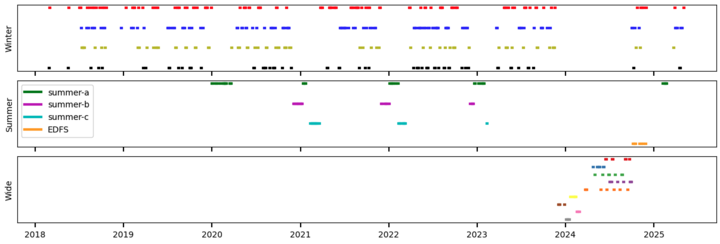

In [126]:
field_times_rough = {}

field_times_rough['winter'] = np.array(
    [Time(['2018-01-01T00:00:00', '2024-01-01T00:00:00']), Time(['2024-09-01T00:00:00', '2025-06-01T00:00:00'])])

field_times_rough['summera'] = np.array(
    [Time(['2019-12-15T00:00:00', '2020-03-15T00:00:00']), Time(['2021-01-01T00:00:00', '2021-02-01T00:00:00']),
     Time(['2021-12-15T00:00:00', '2022-02-15T00:00:00']), Time(['2022-11-01T00:00:00', '2023-03-01T00:00:00']),
     Time(['2024-09-01T00:00:00', '2025-04-01T00:00:00'])])
field_times_rough['summerb'] = np.array(
    [Time(['2020-11-01T00:00:00', '2021-02-15T00:00:00']), Time(['2021-11-01T00:00:00', '2022-02-15T00:00:00']),
     Time(['2022-11-01T00:00:00', '2023-01-01T00:00:00'])])
field_times_rough['summerc'] = np.array(
    [Time(['2021-01-01T00:00:00', '2021-05-01T00:00:00']), Time(['2022-01-01T00:00:00', '2022-04-15T00:00:00']),
     Time(['2023-01-01T00:00:00', '2023-03-15T00:00:00'])])

field_times_rough['widea'] = np.array([Time(['2024-05-01T00:00:00', '2024-11-01T00:00:00'])])
field_times_rough['wideb'] = np.array([Time(['2024-03-01T00:00:00', '2024-08-01T00:00:00'])])
field_times_rough['widec'] = np.array([Time(['2024-03-01T00:00:00', '2024-11-01T00:00:00'])])
field_times_rough['wided'] = np.array([Time(['2024-05-01T00:00:00', '2024-11-01T00:00:00'])])
field_times_rough['widee'] = np.array([Time(['2024-02-01T00:00:00', '2024-11-01T00:00:00'])])
field_times_rough['widef'] = np.array([Time(['2024-01-01T00:00:00', '2024-04-01T00:00:00'])])
field_times_rough['wideg'] = np.array([Time(['2023-11-01T00:00:00', '2024-02-01T00:00:00'])])
field_times_rough['wideh'] = np.array([Time(['2024-01-01T00:00:00', '2024-03-01T00:00:00'])])
field_times_rough['widei'] = np.array([Time(['2023-12-01T00:00:00', '2024-03-01T00:00:00'])])

field_times_rough['gal1'] = np.array(
    [Time(['2023-02-13T00:00:00', '2023-03-22T00:00:00']), Time(['2024-03-01T00:00:00', '2024-03-20T00:00:00'])])
field_times_rough['gal2'] = np.array(
    [Time(['2023-02-13T00:00:00', '2023-03-22T00:00:00']), Time(['2024-03-01T00:00:00', '2024-03-20T00:00:00'])])
field_times_rough['gal3'] = np.array(
    [Time(['2023-02-13T00:00:00', '2023-03-22T00:00:00']), Time(['2024-03-01T00:00:00', '2024-03-20T00:00:00'])])

field_times_rough = {
    key: [[t.utc.mjd for t in interval] for interval in val]
    for key, val in field_times_rough.items()
}
field_times_rough

{'winter': [[58119.0, 60310.0], [60554.0, 60827.0]],
 'summera': [[58832.0, 58923.0],
  [59215.0, 59246.0],
  [59563.0, 59625.0],
  [59884.0, 60004.0],
  [60554.0, 60766.0]],
 'summerb': [[59154.0, 59260.0], [59519.0, 59625.0], [59884.0, 59945.0]],
 'summerc': [[59215.0, 59335.0], [59580.0, 59684.0], [59945.0, 60018.0]],
 'widea': [[60431.0, 60615.0]],
 'wideb': [[60370.0, 60523.0]],
 'widec': [[60370.0, 60615.0]],
 'wided': [[60431.0, 60615.0]],
 'widee': [[60341.0, 60615.0]],
 'widef': [[60310.0, 60401.0]],
 'wideg': [[60249.0, 60341.0]],
 'wideh': [[60310.0, 60370.0]],
 'widei': [[60279.0, 60370.0]],
 'gal1': [[59988.0, 60025.0], [60370.0, 60389.0]],
 'gal2': [[59988.0, 60025.0], [60370.0, 60389.0]],
 'gal3': [[59988.0, 60025.0], [60370.0, 60389.0]]}

In [127]:
SPT_fields.insert(0, 'Active Intervals', None)

In [128]:
for field, intervals in field_times_rough.items():
    SPT_fields.at[field, 'Active Intervals'] = intervals
SPT_fields

,Active Intervals,ra1,ra2,dec1,dec2
field,,,,,
winter,"[[58119.0, 60310.0], [60554.0, 60827.0]]",-50.00,50.00,-70.0,-42.0
summera,"[[58832.0, 58923.0], [59215.0, 59246.0], [5956...",50.00,100.00,-63.0,-28.0
summerb,"[[59154.0, 59260.0], [59519.0, 59625.0], [5988...",0.00,50.00,-42.0,-28.0
summerc,"[[59215.0, 59335.0], [59580.0, 59684.0], [5994...",150.00,225.00,-42.0,-28.0
widea,"[[60431.0, 60615.0]]",14.50,107.00,-28.0,-20.0
wideb,"[[60370.0, 60523.0]]",-78.00,14.50,-28.0,-20.0
widec,"[[60370.0, 60615.0]]",120.00,240.00,-28.0,-20.0
wided,"[[60431.0, 60615.0]]",-85.00,0.00,-42.0,-28.0
widee,"[[60341.0, 60615.0]]",-110.00,-50.00,-70.0,-42.0


# Cross Match

In [129]:
TESS_fields_df

,Sector,Sector Start,Sector End,Ecliptic Plane,Spacecraft Ecliptic Latitude,Spacecraft Ecliptic Longitude,lambda1,lambda2,beta1,beta2
0,1,58324.815972,58352.684028,False,-54.0,315.80,303.80,327.80,-90.0,-6.0
1,2,58353.607639,58381.020833,False,-54.0,343.00,331.00,355.00,-90.0,-6.0
2,3,58382.225694,58408.875000,False,-54.0,10.94,358.94,22.94,-90.0,-6.0
3,4,58410.406250,58436.357639,False,-54.0,38.48,26.48,50.48,-90.0,-6.0
4,5,58437.482639,58463.795139,False,-54.0,65.85,53.85,77.85,-90.0,-6.0
...,...,...,...,...,...,...,...,...,...,...
74,91,60774.791667,60802.263889,True,0.7,229.30,181.30,277.30,-11.3,12.7
75,92,60802.472222,60829.149306,True,0.7,309.70,261.70,357.70,-11.3,12.7
76,93,60829.357639,60855.555556,False,-55.5,266.80,254.80,278.80,-90.0,-7.5
77,94,60855.763889,60881.625000,False,-55.5,291.70,279.70,303.70,-90.0,-7.5


In [130]:
SPT_fields

,Active Intervals,ra1,ra2,dec1,dec2
field,,,,,
winter,"[[58119.0, 60310.0], [60554.0, 60827.0]]",-50.00,50.00,-70.0,-42.0
summera,"[[58832.0, 58923.0], [59215.0, 59246.0], [5956...",50.00,100.00,-63.0,-28.0
summerb,"[[59154.0, 59260.0], [59519.0, 59625.0], [5988...",0.00,50.00,-42.0,-28.0
summerc,"[[59215.0, 59335.0], [59580.0, 59684.0], [5994...",150.00,225.00,-42.0,-28.0
widea,"[[60431.0, 60615.0]]",14.50,107.00,-28.0,-20.0
wideb,"[[60370.0, 60523.0]]",-78.00,14.50,-28.0,-20.0
widec,"[[60370.0, 60615.0]]",120.00,240.00,-28.0,-20.0
wided,"[[60431.0, 60615.0]]",-85.00,0.00,-42.0,-28.0
widee,"[[60341.0, 60615.0]]",-110.00,-50.00,-70.0,-42.0


## Time overlap

In [131]:
SPT_fields.insert(1, 'sectors', None)

In [132]:
sector_starts = TESS_fields_df['Sector Start'].to_numpy()
sector_ends = TESS_fields_df['Sector End'].to_numpy()

for field, data in SPT_fields.iterrows():
    print(field)
    SPT_fields.at[field, 'sectors'] = list()
    intervals = data['Active Intervals']
    for interval in intervals:
        print('\t',interval)
        min_idx = np.searchsorted(sector_starts, interval[0])
        min_idx = min_idx - 1 if min_idx > 0 else 0
        max_idx = np.searchsorted(sector_ends, interval[1])
        print('\t',min_idx, max_idx)
        if TESS_fields_df.loc[min_idx, 'Sector End'] < interval[0]: min_idx = min_idx + 1
        if TESS_fields_df.loc[max_idx, 'Sector Start'] > interval[1]: max_idx = max_idx - 1
        print('\t',min_idx, max_idx)
        valid_sectors = TESS_fields_df.loc[min_idx : max_idx, 'Sector'].to_list()
        print('\t',valid_sectors)
        if SPT_fields.at[field, 'sectors'] == None: SPT_fields.at[field, 'sectors'] = valid_sectors
        else: SPT_fields.at[field, 'sectors'] = SPT_fields.at[field, 'sectors'] + valid_sectors
        


winter
	 [58119.0, 60310.0]
	 0 62
	 0 62
	 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17, 18, 19, 20, 21, 22, 23, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
	 [60554.0, 60827.0]
	 65 75
	 65 75
	 [82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
summera
	 [58832.0, 58923.0]
	 15 18
	 15 18
	 [19, 20, 21, 22]
	 [59215.0, 59246.0]
	 26 27
	 26 27
	 [33, 34]
	 [59563.0, 59625.0]
	 37 39
	 37 39
	 [46, 47, 48]
	 [59884.0, 60004.0]
	 47 51
	 47 51
	 [58, 59, 60, 61, 62]
	 [60554.0, 60766.0]
	 65 73
	 65 73
	 [82, 83, 84, 85, 86, 87, 88, 89, 90]
summerb
	 [59154.0, 59260.0]
	 24 28
	 24 28
	 [31, 32, 33, 34, 35]
	 [59519.0, 59625.0]
	 35 39
	 35 39
	 [44, 45, 46, 47, 48]
	 [59884.0, 59945.0]
	 47 49
	 47 49
	 [58, 59, 60]
summerc
	 [59215.0, 59335.0]
	 26 31
	 26 31
	 [33, 34, 35, 36, 37, 38]
	 [59580.0, 59684.0]
	 38 41
	 38 41
	 [47, 48, 49, 50]
	 [59945.0, 60018.0]

In [135]:
SPT_fields

,Active Intervals,sectors,ra1,ra2,dec1,dec2
field,,,,,,
winter,"[[58119.0, 60310.0], [60554.0, 60827.0]]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17...",-50.00,50.00,-70.0,-42.0
summera,"[[58832.0, 58923.0], [59215.0, 59246.0], [5956...","[19, 20, 21, 22, 33, 34, 46, 47, 48, 58, 59, 6...",50.00,100.00,-63.0,-28.0
summerb,"[[59154.0, 59260.0], [59519.0, 59625.0], [5988...","[31, 32, 33, 34, 35, 44, 45, 46, 47, 48, 58, 5...",0.00,50.00,-42.0,-28.0
summerc,"[[59215.0, 59335.0], [59580.0, 59684.0], [5994...","[33, 34, 35, 36, 37, 38, 47, 48, 49, 50, 60, 6...",150.00,225.00,-42.0,-28.0
widea,"[[60431.0, 60615.0]]","[80, 81, 82, 83, 84, 85]",14.50,107.00,-28.0,-20.0
wideb,"[[60370.0, 60523.0]]","[80, 81]",-78.00,14.50,-28.0,-20.0
widec,"[[60370.0, 60615.0]]","[80, 81, 82, 83, 84, 85]",120.00,240.00,-28.0,-20.0
wided,"[[60431.0, 60615.0]]","[80, 81, 82, 83, 84, 85]",-85.00,0.00,-42.0,-28.0
widee,"[[60341.0, 60615.0]]","[80, 81, 82, 83, 84, 85]",-110.00,-50.00,-70.0,-42.0


In [136]:
SPT_fields.to_csv('..\data\possible_tess_sectors.csv')

## Field Overlap

In [141]:
SPT_field_field_filtered = SPT_fields
SPT_field_field_filtered

,Active Intervals,sectors,ra1,ra2,dec1,dec2
field,,,,,,
winter,"[[58119.0, 60310.0], [60554.0, 60827.0]]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 27...",-50.00,50.00,-70.0,-42.0
summera,"[[58832.0, 58923.0], [59215.0, 59246.0], [5956...","[33, 34, 61, 62, 87, 88, 89, 90]",50.00,100.00,-63.0,-28.0
summerb,"[[59154.0, 59260.0], [59519.0, 59625.0], [5988...","[31, 32, 33, 34, 35]",0.00,50.00,-42.0,-28.0
summerc,"[[59215.0, 59335.0], [59580.0, 59684.0], [5994...","[33, 34, 35, 36, 37, 38, 61, 62, 63]",150.00,225.00,-42.0,-28.0
widea,"[[60431.0, 60615.0]]",[80],14.50,107.00,-28.0,-20.0
wideb,"[[60370.0, 60523.0]]",[80],-78.00,14.50,-28.0,-20.0
widec,"[[60370.0, 60615.0]]",[80],120.00,240.00,-28.0,-20.0
wided,"[[60431.0, 60615.0]]",[],-85.00,0.00,-42.0,-28.0
widee,"[[60341.0, 60615.0]]",[],-110.00,-50.00,-70.0,-42.0


Start with some loose field cuts
- beta > 23.5 will always have dec > 0 (FILTERED OUT ABOVE)
- dec > 0 after transform

In [142]:
TESS_fields_by_sector = TESS_fields_df.set_index('Sector')

for field, data in SPT_field_field_filtered.iterrows():
    print(field)
    ov_secs = list()
    
    sectors = data['sectors']
    for sector in sectors:
        lambda1 = TESS_fields_by_sector.at[sector, 'lambda1']
        lambda2 = TESS_fields_by_sector.at[sector, 'lambda2']
        beta1 = TESS_fields_by_sector.at[sector, 'beta1']
        beta2 = TESS_fields_by_sector.at[sector, 'beta2']
        tess_coords_ecl = SkyCoord([
            (lambda1, beta1),
            (lambda2, beta1),
            (lambda2, beta2),
            (lambda1, beta2)
        ] * u.deg, frame='barycentrictrueecliptic')
        tess_coords_icrs = tess_coords_ecl.transform_to('icrs')
        if tess_coords_icrs.dec.min().value > (data['dec2'] + 5): continue
        else: ov_secs.append(sector)
    print(ov_secs)
    SPT_field_field_filtered.at[field,'sectors'] = ov_secs

winter
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 61, 62, 63, 64, 65, 66, 67, 68, 69, 87, 88, 89, 90]
summera
[33, 34, 61, 62, 87, 88, 89, 90]
summerb
[31, 32, 33, 34, 35]
summerc
[33, 34, 35, 36, 37, 38, 61, 62, 63]
widea
[80]
wideb
[80]
widec
[80]
wided
[]
widee
[]
widef
[]
wideg
[]
wideh
[]
widei
[]
gal1
[62, 63]
gal2
[62, 63]
gal3
[62, 63]


In [139]:
SPT_field_field_filtered

,Active Intervals,sectors,ra1,ra2,dec1,dec2
field,,,,,,
winter,"[[58119.0, 60310.0], [60554.0, 60827.0]]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 27...",-50.00,50.00,-70.0,-42.0
summera,"[[58832.0, 58923.0], [59215.0, 59246.0], [5956...","[33, 34, 61, 62, 87, 88, 89, 90]",50.00,100.00,-63.0,-28.0
summerb,"[[59154.0, 59260.0], [59519.0, 59625.0], [5988...","[31, 32, 33, 34, 35]",0.00,50.00,-42.0,-28.0
summerc,"[[59215.0, 59335.0], [59580.0, 59684.0], [5994...","[33, 34, 35, 36, 37, 38, 61, 62, 63]",150.00,225.00,-42.0,-28.0
widea,"[[60431.0, 60615.0]]",[80],14.50,107.00,-28.0,-20.0
wideb,"[[60370.0, 60523.0]]",[80],-78.00,14.50,-28.0,-20.0
widec,"[[60370.0, 60615.0]]",[80],120.00,240.00,-28.0,-20.0
wided,"[[60431.0, 60615.0]]",[],-85.00,0.00,-42.0,-28.0
widee,"[[60341.0, 60615.0]]",[],-110.00,-50.00,-70.0,-42.0


In [140]:
SPT_fields.to_csv('..\data\possible_tess_sectors_field_filtered.csv')

## Try some more robust filtering
Not necessary atm

In [56]:
from spherical_geometry.polygon import SphericalPolygon

# Sectors in Northern Ecliptic Hemisphere
N_sectors = np.concatenate((np.arange(14,26+1),np.arange(40,41+1),np.arange(47,55+1),np.arange(56,60+1),np.arange(73,83+1),np.arange(84,86+1)))

# Construct southern pole region observed by TESS
edge_beta = - 90 + 12
lambdas = np.linspace(0, 360, 12, endpoint=False)
betas = np.full_like(lambdas, edge_beta)
lambdas = np.append(lambdas, 0)
betas = np.append(betas, -90)
ecl_coords = SkyCoord(lon=lambdas*u.deg, lat=betas*u.deg, frame='barycentrictrueecliptic')
icrs_coords = ecl_coords.transform_to('icrs')
southern_pole = SphericalPolygon.from_radec(icrs_coords.ra.deg, icrs_coords.dec.deg)

TESS_fields_by_sector = TESS_fields_df.set_index('Sector')
for field, data in SPT_fields.iterrows():
    print(field)
    ov_secs = list()
    ra1 = data['ra1']
    ra2 = data['ra2']
    dec1 = data['dec1']
    dec2 = data['dec2']
    spt_coords = SkyCoord(
        ra=[ra1, ra2, ra2, ra1]*u.deg,
        dec=[dec1, dec1, dec2, dec2]*u.deg,
        frame='icrs'
    )
    spt_poly = SphericalPolygon.from_radec(
        spt_coords.ra.deg,
        spt_coords.dec.deg,
        center= ((ra1+ra2)/2 *u.deg, (dec1+dec2)/2 *u.deg)
    )
    
    sectors = data['sectors']
    for sector in sectors:
        lambda1 = TESS_fields_by_sector.at[sector, 'lambda1']
        lambda2 = TESS_fields_by_sector.at[sector, 'lambda2']
        beta1 = TESS_fields_by_sector.at[sector, 'beta1']
        beta2 = TESS_fields_by_sector.at[sector, 'beta2']
        tess_coords_ecl = SkyCoord([
            (lambda1, beta1),
            (lambda2, beta1),
            (lambda2, beta2),
            (lambda1, beta2)
        ] * u.deg, frame='barycentrictrueecliptic')
        tess_coords_icrs = tess_coords_ecl.transform_to('icrs')
        tess_poly = SphericalPolygon.from_radec(
            tess_coords_icrs.ra.deg,
            tess_coords_icrs.dec.deg,
            center= (TESS_fields_by_sector.at[sector, 'Spacecraft Ecliptic Longitude'] * u.deg, TESS_fields_by_sector.at[sector, 'Spacecraft Ecliptic Latitude'] * u.deg),
        )
        if tess_poly.intersects_poly(spt_poly): 
            print('\t', sector, 'main_field')
            ov_secs.append(sector)
        elif sector not in N_sectors and not TESS_fields_by_sector.at[sector, 'Ecliptic Plane'] and southern_pole.intersects_poly(spt_poly): 
            print('\t', sector, 'south pole')
            ov_secs.append(sector)
    print(ov_secs)
    SPT_fields.at[field,'sectors'] = ov_secs

ModuleNotFoundError: No module named 'spherical_geometry'

In [ ]:
SPT_fields